In [58]:
from helper_code import *
import numpy as np, os, sys, joblib
import ecg_plot
import pandas as pd
from glob import glob
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tsai.all import *
import torch
import optuna
from optuna.integration import FastAIPruningCallback
from sklearn.metrics import classification_report
import transformation_funcs as tfs
import seaborn as sns
from torchsummary import summary
import amir_tools as at
torch.cuda.set_device(1)

In [59]:
def snomedConvert(label_df,snomed=True):
    codes =  pd.read_csv("data/snomed_codes.csv",sep=",")[["Dx","SNOMEDCTCode"]]
    if snomed:
        label_df.columns = [codes[codes["SNOMEDCTCode"] == int(x)]["Dx"].item() for x in label_df.columns]
        return label_df
DATASET_NAME = "WFDB_CPSC2018_signitured"
X = np.load('./data/big_numpy_datasets/%s.npy'%DATASET_NAME, mmap_mode='c')
label_df = pd.read_csv("data/%s.csv"%DATASET_NAME).drop(columns=["headers","leads"])
y = snomedConvert(label_df)


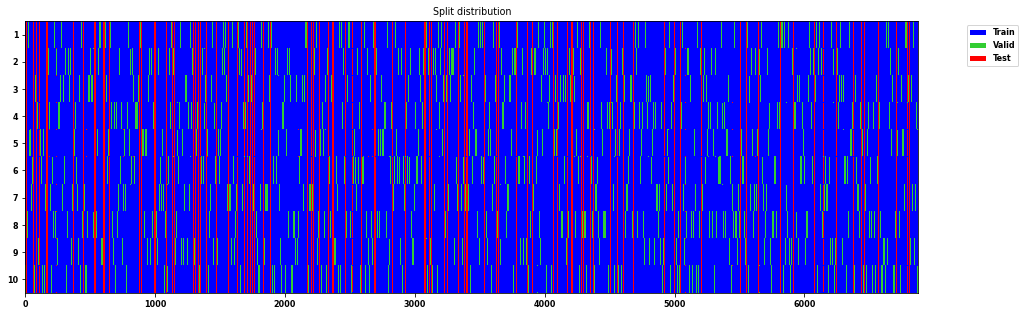

Counts by label: {'right bundle branch block': 1857, 'sinus rhythm': 918, 'atrial fibrillation': 1221, 'ventricular ectopics': 700, 'st depression': 869, 'left bundle branch block': 236, 'st elevation': 220, '1st degree av block': 722, 'premature atrial contraction': 616}


In [60]:

cv_splits = get_splits(y.to_numpy(), n_splits = 10, valid_size=.1,test_size=0.1, stratify=False, random_state=23, shuffle=True)
y_multi = []
for i,row in y.iterrows():
    sample_labels = []
    for i,r in enumerate(row):
        if r == True:
            sample_labels.append(y.columns[i])
        
    y_multi.append(list(tuple(sample_labels)))
label_counts = collections.Counter([a for r in y_multi for a in r])
print('Counts by label:', dict(label_counts))

In [ ]:
max_len = 8000
sf = 0.4
tfms  = [None, TSMultiLabelClassification()]
# batch_tfms = [
#              TSStandardize(by_sample=True),
#                 tfs.Scale(scale_factor=sf,),
#                 tfs.Normalize(),
#                 tfs.BandPass(int(sf*500),low_cut=50, high_cut=1,leads=12,),
#                 tfs.RandomShift(0.1),
#                 tfs.MulNoise(6),
#                 tfs.CutOutWhenTraining(),
#              ]
batch_tfms = [
    tfs.Normalize(),
    tfs.Scale(scale_factor=sf)
 ]
for cv_num in range(5):
#     cv_num = cv_num + 0
    dsets = TSDatasets(X.astype(float)[:,:,0:max_len], y_multi, tfms=tfms, splits=cv_splits[cv_num]) # inplace=True by default
    dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
    metrics =[accuracy_multi, balanced_accuracy_multi, precision_multi, recall_multi, specificity_multi, F1_multi] 
    # model = MiniRocketPlus(dls.vars, dls.c,2500)
    model = MultiInceptionTimePlus(dls.vars, dls.c, dls.len, depth=13, ks = 110,nf=32 )
    # try : loss_func = BCEWithLogitsLossFlat(pos_weight=dls.train.cws.sqrt())
    
    learn = Learner(dls, model, metrics=metrics,
#                     opt_func = wrap_optimizer(torch.optim.Adam,weight_decay=6.614e-07),
                    cbs=[ShowGraph(),fastai.callback.all.SaveModelCallback(monitor="F1_multi",fname="inception_augmented_%s_%s_nf8"%(max_len,cv_num))],
                    model_dir="models/10CV/")
    learn.fit_one_cycle(300, lr_max=0.01)
    learn.recorder.plot_metrics()

### check f1s

In [62]:
max_len = 12000
sf = 0.4
batch_tfms = [
                tfs.Normalize(),
                tfs.Scale(scale_factor=sf,),
             ]
tfms  = [None, TSMultiLabelClassification()]
reports = []
probas_list, targets_list = [],[]
for cv_num in range(10):
    fold_splits = cv_splits[cv_num]
    dsets = TSDatasets(X.astype(float)[:,:,0:max_len], y_multi, tfms=tfms, splits=(fold_splits[0],fold_splits[2])) # inplace=True by default
    dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[128, 128], batch_tfms=batch_tfms, num_workers=0)
    metrics =[accuracy_multi, balanced_accuracy_multi, precision_multi, recall_multi, specificity_multi, F1_multi] 
    
#     model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=13, ks = 110,nf=28 )
    model = MultiInceptionTimePlus(dls.vars, dls.c, dls.len, depth=12, ks = 130,nf=28 )
    learn = Learner(dls, model, metrics=metrics, 
                    cbs=[ShowGraph()],
                    model_dir="models/10CV/")
    learn.load("multiinception_%s_%s"%(max_len,cv_num))
    valid_probas, valid_targets, valid_preds = learn.get_preds(dl=dls.valid, with_decoded=True)
    probas_list.append(valid_probas)
    targets_list.append(valid_targets)
    y_pred = (valid_preds>0)
    y_test = valid_targets

    report = classification_report(y_test, y_pred,target_names = dls.vocab.o2i.keys(),digits=3,output_dict=True)
    reports.append(report)

In [63]:
for report in reports:
    for k,v in report.items():
        report[k] = report[k]["f1-score"]
pd.DataFrame(reports).median()

1st degree av block             0.861538
atrial fibrillation             0.937499
left bundle branch block        0.926829
premature atrial contraction    0.754606
right bundle branch block       0.946153
sinus rhythm                    0.793565
st depression                   0.821075
st elevation                    0.486842
ventricular ectopics            0.855457
micro avg                       0.864626
macro avg                       0.817559
weighted avg                    0.861419
samples avg                     0.840369
dtype: float64

In [64]:

df = pd.DataFrame(reports)
df.columns = [at.label_convert_ICBEB(x) for x in df.columns]
sorted(dict(df[df.columns].median()).items())

[('AF', 0.9374989149117172),
 ('I-AVB', 0.8615384615384616),
 ('LBBB', 0.9268292682926829),
 ('PAC', 0.7546061415220294),
 ('PVC', 0.8554565081133784),
 ('RBBB', 0.9461534921334132),
 ('STD', 0.8210747213430577),
 ('STE', 0.48684210526315796),
 ('macro avg', 0.8175585337793301),
 ('micro avg', 0.8646257876929926),
 ('normal', 0.7935645272601795),
 ('samples avg', 0.8403687530325086),
 ('weighted avg', 0.8614188794028119)]

In [72]:
winner = dict(zip(["normal","AF","I-AVB","LBBB","RBBB","PAC","PVC","STD","STE"],[0.795,0.897,0.865,0.821,0.911,0.734,0.852,0.788,0.509]))
winner_ensemble = dict(zip(["normal","AF","I-AVB","LBBB","RBBB","PAC","PVC","STD","STE"],[0.808,0.933,0.875,0.884,0.910,0.826,0.869,0.811,0.624]))
# inception_augmented = dict(zip(["RBBB","PVC","AF","LBBB","STE","I-AVB","PAC","normal","STD"],[0.935,0.682,0.944,0.884,0.450,0.846,0.474, 0.731,0.778]))
inception = dict({('AF', 0.9333495373183562),
 ('I-AVB', 0.858288770053476),
 ('LBBB', 0.9047619047619047),
 ('PAC', 0.7544467544467544),
 ('PVC', 0.8245720345402212),
 ('RBBB', 0.9402660837651122),
 ('STD', 0.8101123595505617),
 ('STE', 0.5058139534883721),
 ('normal', 0.8044138182259728),})

# multi_inception = dict({('AF', 0.9364395367627256),
#  ('I-AVB', 0.8679084073820916),
#  ('LBBB', 0.8973684210526316),
#  ('PAC', 0.7555713608345187),
#  ('PVC', 0.8184435856634084),
#  ('RBBB', 0.9434443563309542),
#  ('STD', 0.7998738511443504),
#  ('STE', 0.48809523809523814),
#  ('normal', 0.8098997874278773),})

multi_inception = dict({('AF', 0.9374989149117172),
 ('I-AVB', 0.8615384615384616),
 ('LBBB', 0.9268292682926829),
 ('PAC', 0.7546061415220294),
 ('PVC', 0.8554565081133784),
 ('RBBB', 0.9461534921334132),
 ('STD', 0.8210747213430577),
 ('STE', 0.48684210526315796),
 ('normal', 0.7935645272601795),})


winner = dict(sorted(winner.items()))
winner_ensemble = dict(sorted(winner_ensemble.items()))
# inception = dict(sorted(inception.items()))
inception_augmented = dict(sorted(inception_augmented.items()))
df = pd.DataFrame([winner_ensemble,winner,inception,multi_inception],index=["winner_ensemble","winner","inception","multi_inception"]).T
df["performance"] = df["winner_ensemble"]<df["multi_inception"]
df

,winner_ensemble,winner,inception,multi_inception,performance
AF,0.933,0.897,0.933350,0.937499,True
I-AVB,0.875,0.865,0.858289,0.861538,False
LBBB,0.884,0.821,0.904762,0.926829,True
PAC,0.826,0.734,0.754447,0.754606,False
PVC,0.869,0.852,0.824572,0.855457,False
RBBB,0.910,0.911,0.940266,0.946153,True
STD,0.811,0.788,0.810112,0.821075,True
STE,0.624,0.509,0.505814,0.486842,False
normal,0.808,0.795,0.804414,0.793565,False


In [68]:
df.mean()

winner_ensemble    0.837778
winner             0.796889
inception          0.815114
multi_inception    0.820396
performance        0.666667
dtype: float64

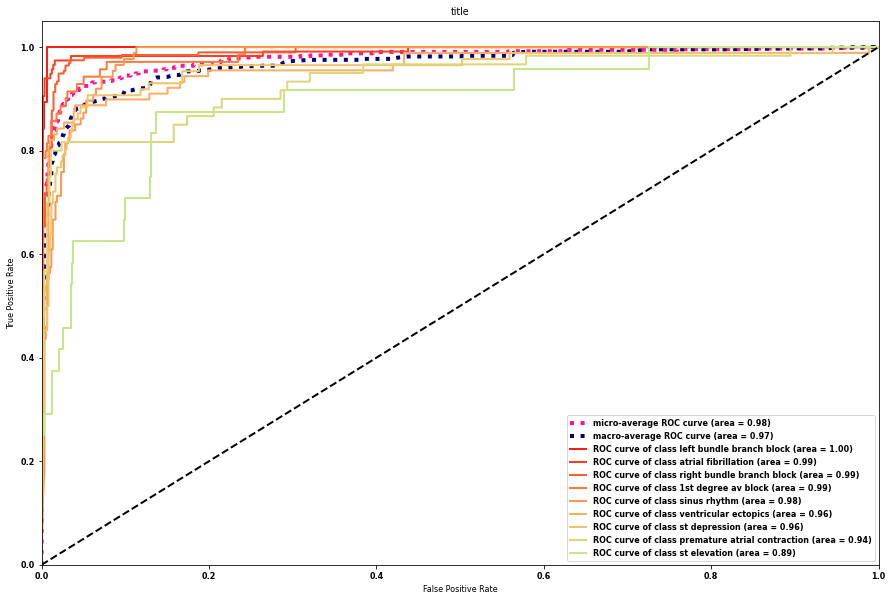

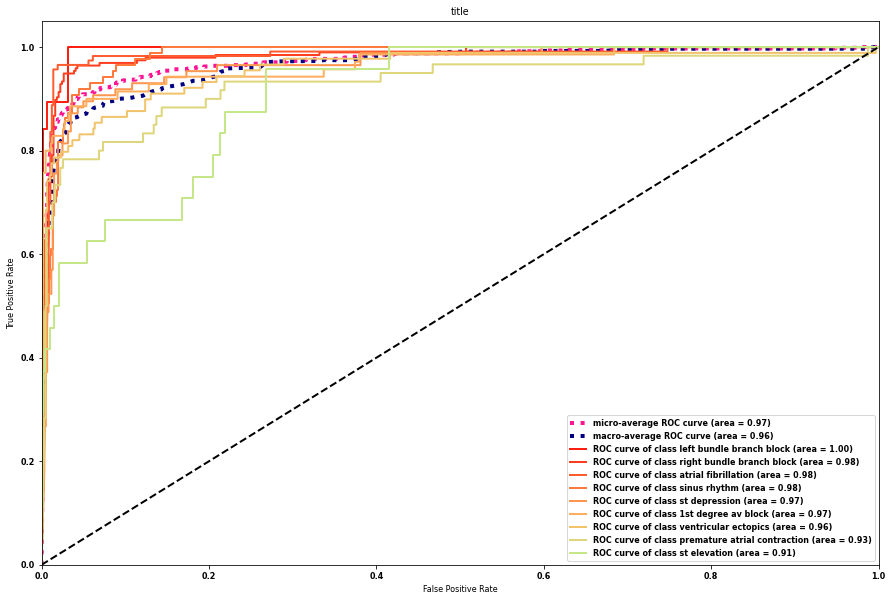

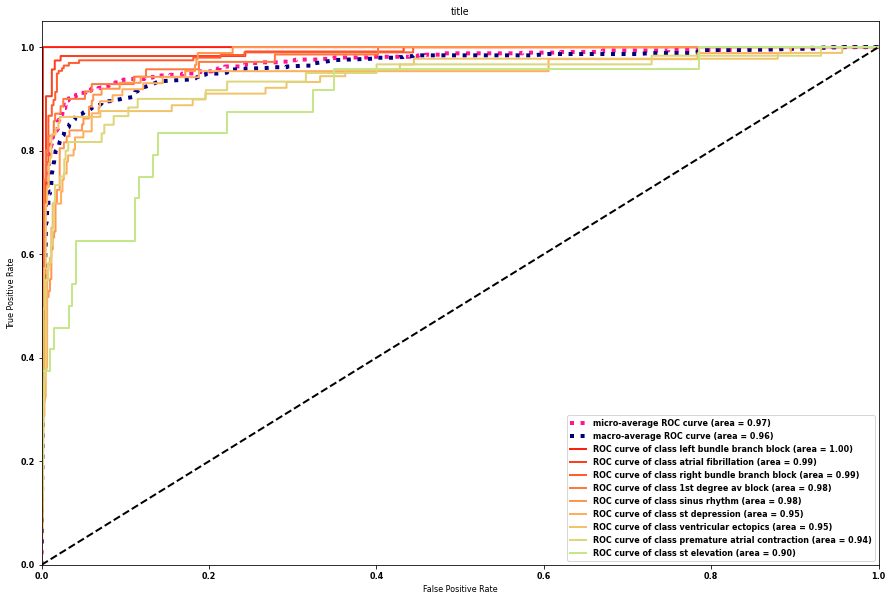

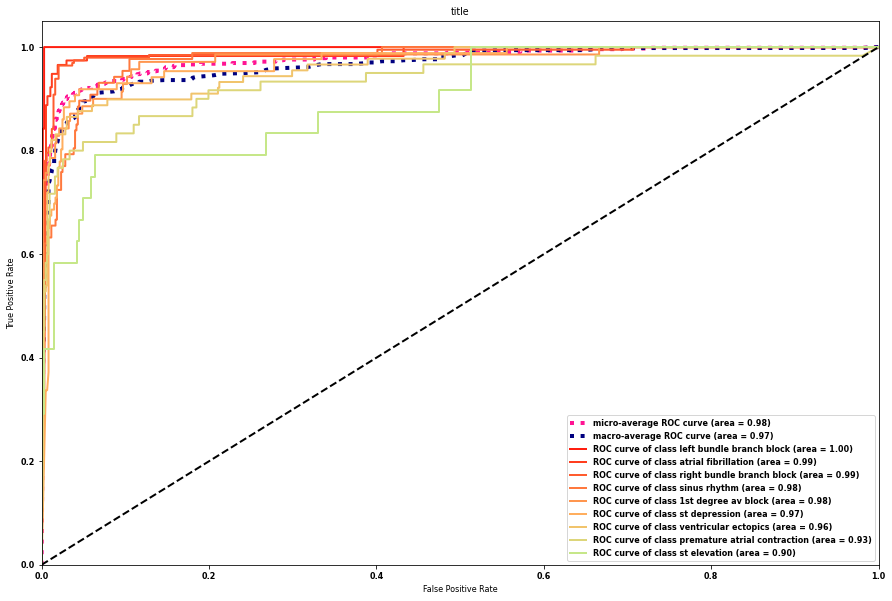

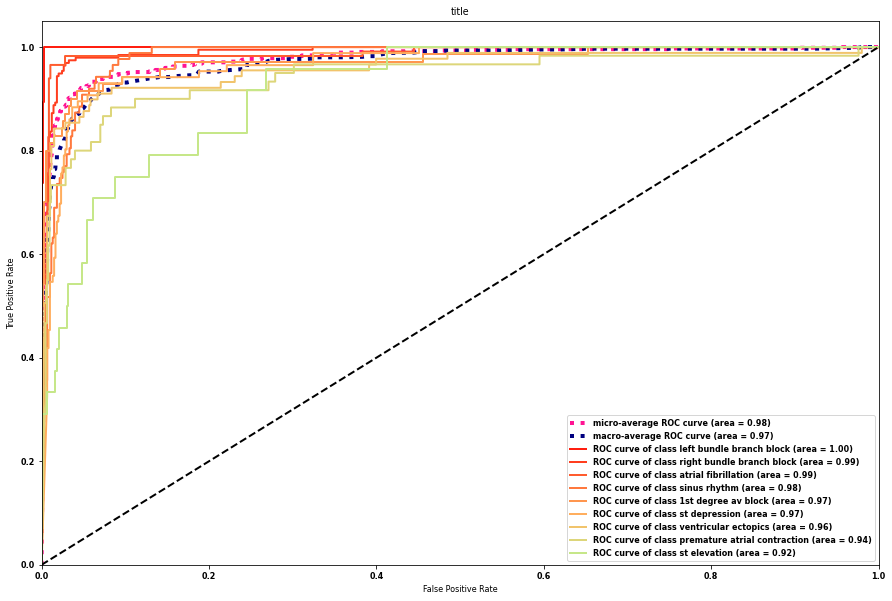

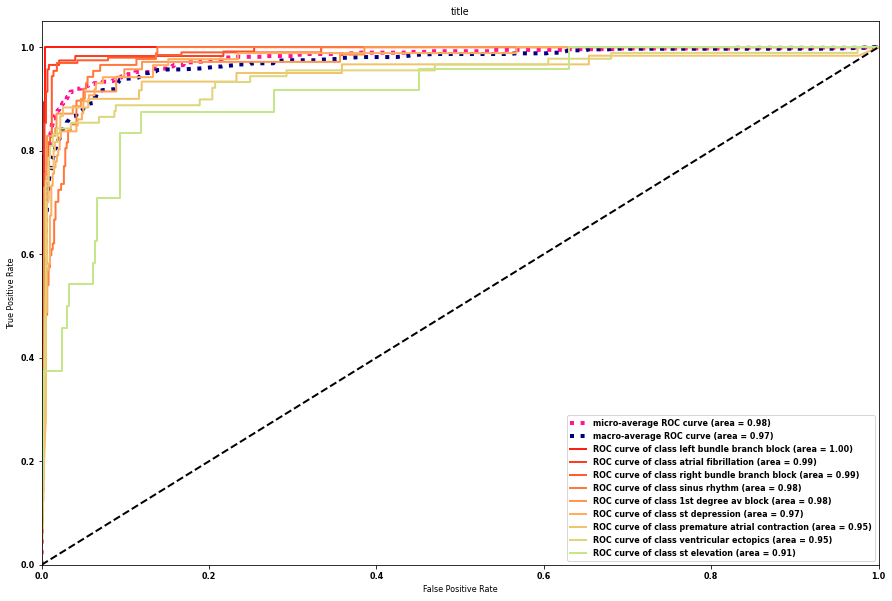

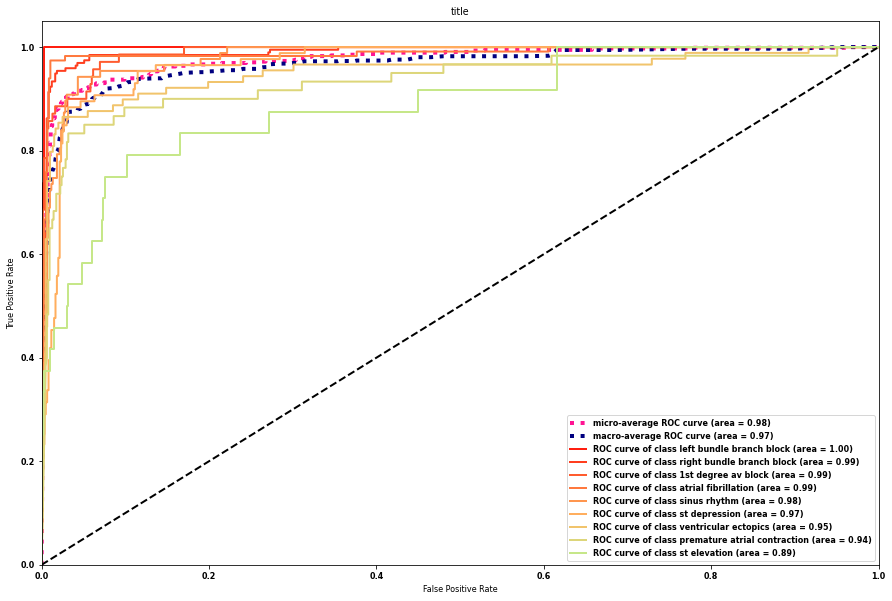

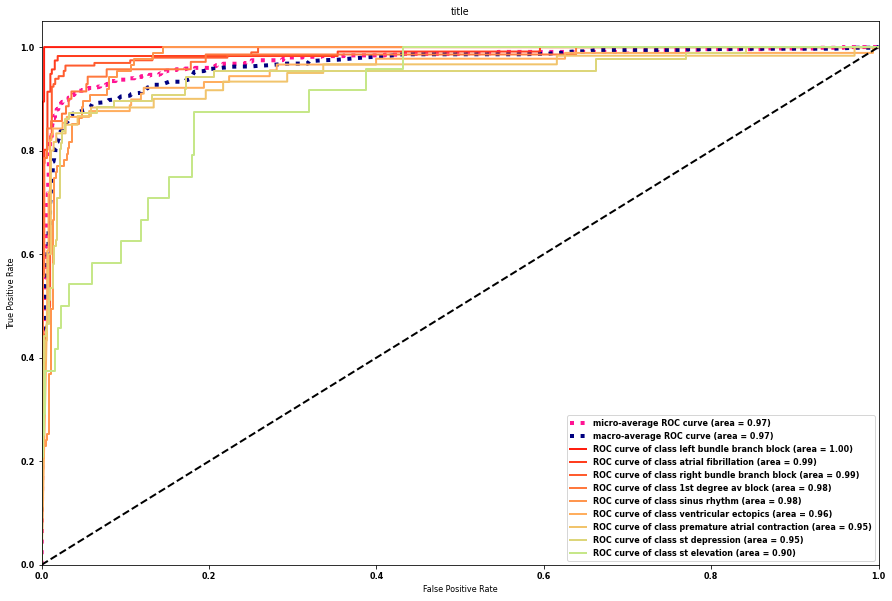

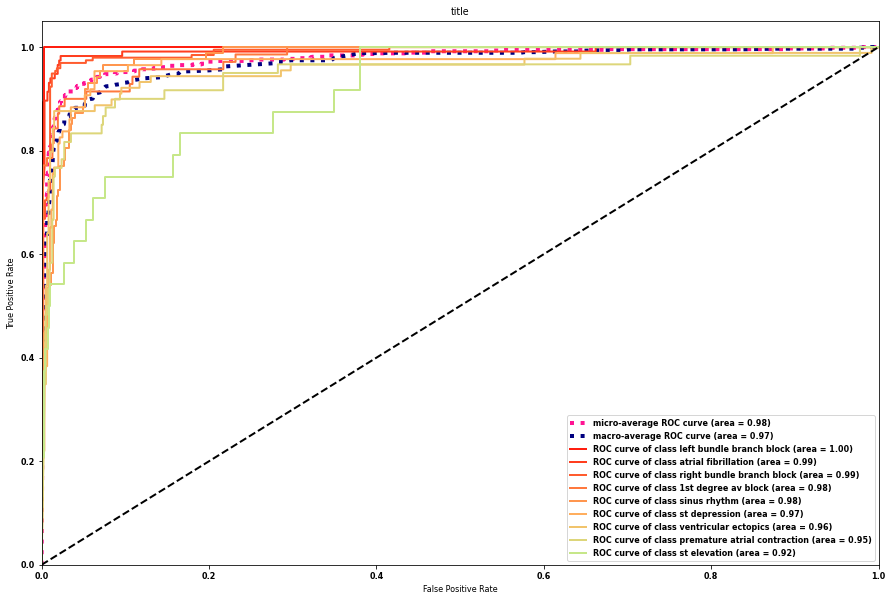

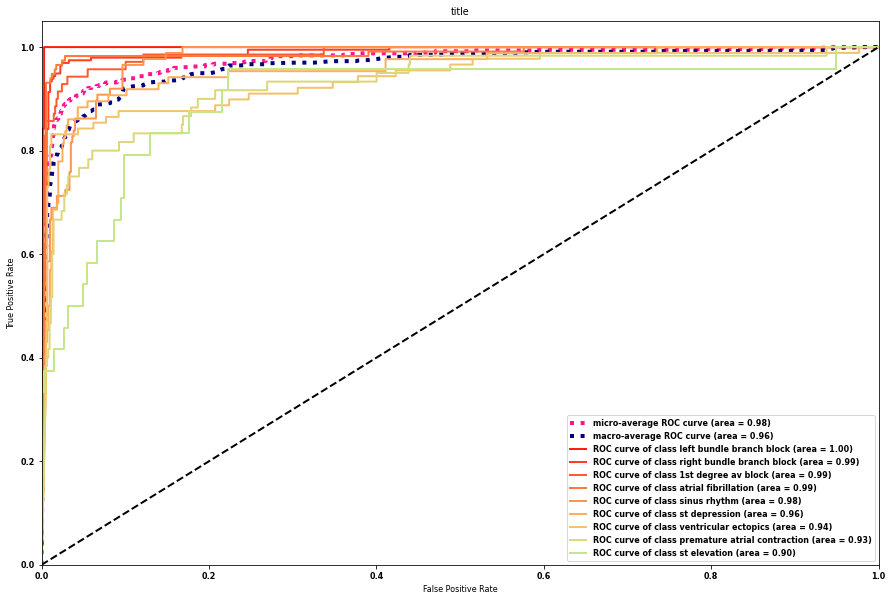

In [69]:


aucs_list = []
for targets,probs in zip(targets_list,probas_list):
    fig, aucs = at.draw_aucs(targets,probs,list(dls.vocab.o2i.keys()))
    aucs_list.append(dict(aucs))

In [70]:
df = pd.DataFrame(aucs_list)
df.mean().mean()

0.9662592153133185

In [71]:
df

,left bundle branch block,atrial fibrillation,right bundle branch block,1st degree av block,sinus rhythm,ventricular ectopics,st depression,premature atrial contraction,st elevation
0,0.999212,0.992127,0.990554,0.986826,0.981015,0.959190,0.958383,0.935792,0.894859
1,0.996061,0.983612,0.984444,0.965432,0.982835,0.956888,0.965445,0.930409,0.910759
2,0.998858,0.990375,0.988029,0.979185,0.975077,0.945492,0.947481,0.939819,0.897122
3,0.999173,0.988262,0.986284,0.975492,0.977720,0.961914,0.969392,0.934623,0.898819
4,0.999448,0.987643,0.989640,0.973373,0.981600,0.958720,0.967825,0.943142,0.920060
5,0.998976,0.993055,0.989786,0.979509,0.982500,0.947606,0.974316,0.952406,0.911011
6,0.999133,0.987854,0.990757,0.989454,0.981897,0.951496,0.971056,0.935872,0.889832
7,0.998858,0.989228,0.986694,0.979301,0.978429,0.955413,0.946020,0.947222,0.902401
8,0.999448,0.991070,0.990414,0.980898,0.980594,0.957395,0.968280,0.945906,0.916290
9,0.998700,0.987831,0.990315,0.988226,0.977701,0.939856,0.957871,0.930635,0.903406


In [73]:
import argparse

parser = argparse.ArgumentParser(description='Process some integers.')
parser.add_argument('integers', metavar='N', type=int, nargs='+',
                    help='an integer for the accumulator')
parser.add_argument('--sum', dest='accumulate', action='store_const',
                    const=sum, default=max,
                    help='sum the integers (default: find the max)')

args = parser.parse_args()
print(args.accumulate(args.integers))

usage: ipykernel_launcher.py [-h] [--sum] N [N ...]
ipykernel_launcher.py: error: argument N: invalid int value: '/home/amirsalimi/.local/share/jupyter/runtime/kernel-3dbe8aa2-51b2-45af-b342-90d0b19c146b.json'
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/amirsalimi/miniconda3/envs/ecg2/lib/python3.8/argparse.py", line 2422, in _get_value
    result = type_func(arg_string)
ValueError: invalid literal for int() with base 10: '/home/amirsalimi/.local/share/jupyter/runtime/kernel-3dbe8aa2-51b2-45af-b342-90d0b19c146b.json'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/amirsalimi/miniconda3/envs/ecg2/lib/python3.8/argparse.py", line 1800, in parse_known_args
    namespace, args = self._parse_known_args(args, namespace)
  File "/home/amirsalimi/miniconda3/envs/ecg2/lib/python3.8/argparse.py", line 2009, in _parse_known_args
    stop_index = consume_positionals(start_index)
  File "/home/amirsalimi/miniconda3/envs/ecg2/lib/python3.8/argparse.py", line 1965, in consume_positionals
    take_action(action, args)
  File "/home/amirsalimi/miniconda3/envs/ecg2/lib/python3.8/argparse.py", line 1858, in take_action
    argument_val

TypeError: object of type 'NoneType' has no len()